#Europe Analysis

##Berlin

In [ ]:
import pandas as pd
import numpy as np

fn = "Berlin.csv"
df = pd.read_csv(fn)

print("shape:", df.shape)
print("columns:", df.columns.tolist())
print(df.head(5))
print("\nmissing per column:\n", df.isna().sum())

shape: (43848, 9)
columns: ['date', 'pm10', 'pm2_5', 'ammonia', 'carbon_monoxide', 'nitrogen_dioxide', 'carbon_dioxide', 'sulphur_dioxide', 'methane']
                        date  pm10  pm2_5  ammonia  carbon_monoxide  \
0  2020-12-01 00:00:00+00:00  19.3   15.2      1.0            228.0   
1  2020-12-01 01:00:00+00:00  19.2   16.0      0.8            212.0   
2  2020-12-01 02:00:00+00:00  19.5   16.8      0.6            216.0   
3  2020-12-01 03:00:00+00:00  21.1   18.3      0.6            219.0   
4  2020-12-01 04:00:00+00:00  22.5   19.9      0.5            220.0   

   nitrogen_dioxide  carbon_dioxide  sulphur_dioxide  methane  
0              20.0             NaN              2.9      NaN  
1              18.1             NaN              2.9      NaN  
2              18.0             NaN              2.6      NaN  
3              18.3             NaN              2.5      NaN  
4              19.3             NaN              2.5      NaN  

missing per column:
 date            

In [ ]:
df.columns = (
    df.columns.str.strip()
              .str.lower()
              .str.replace(" ", "_")
              .str.replace("-", "_")
)

print(df.columns.tolist())

['date', 'pm10', 'pm2_5', 'ammonia', 'carbon_monoxide', 'nitrogen_dioxide', 'carbon_dioxide', 'sulphur_dioxide', 'methane']


In [ ]:
candidates = ["datetime", "date_time", "date", "time", "timestamp"]
dt_col = None

for c in candidates:
    if c in df.columns:
        dt_col = c
        break

if dt_col is None:
    raise RuntimeError("No datetime column found. Rename your column to one of: " + ", ".join(candidates))

df["datetime"] = pd.to_datetime(df[dt_col], errors="coerce")
print("Parsed datetime:", dt_col, " — nulls:", df["datetime"].isna().sum())

df = df[~df["datetime"].isna()].copy()
df = df.sort_values("datetime").reset_index(drop=True)

print("After datetime cleaning, rows:", len(df))

Parsed datetime: date  — nulls: 0
After datetime cleaning, rows: 43848


In [ ]:
pollutants = [
    "pm10","pm2_5","ammonia",
    "carbon_monoxide","nitrogen_dioxide",
    "carbon_dioxide","sulphur_dioxide","methane"
]

# try to fix common alternative column names
col_map = {}
for p in pollutants:
    if p not in df.columns:
        alternatives = [
            p.replace("_",""),
            p.replace("2_5","2.5"),
            p.replace("pm2_5","pm2.5"),
            p.replace("pm2_5","pm25"),
        ]
        for alt in alternatives:
            if alt in df.columns:
                col_map[alt] = p

if col_map:
    df = df.rename(columns=col_map)
    print("Renamed columns:", col_map)

missing = [p for p in pollutants if p not in df.columns]
if missing:
    print("Warning: Missing pollutant columns:", missing)

# convert to numeric
for p in pollutants:
    if p in df.columns:
        df[p] = (
            df[p].astype(str)
                 .str.replace("<","")
                 .str.replace(",","")
                 .str.strip()
        )
        df[p] = pd.to_numeric(df[p], errors="coerce")

In [ ]:
# negative values → NaN
for p in pollutants:
    if p in df.columns:
        df.loc[df[p] < 0, p] = np.nan

# cap at 99.9 percentile (pollutant-dependent)
for p in pollutants:
    if p in df.columns:
        q = df[p].quantile(0.999)
        if pd.notna(q) and q > 0:
            df.loc[df[p] > q, p] = np.nan
        print(f"{p}: capped at {q}")

pm10: capped at 55.8
pm2_5: capped at 44.0
ammonia: capped at 9.2
carbon_monoxide: capped at 609.1530000000057
nitrogen_dioxide: capped at 64.16120000000228
carbon_dioxide: capped at 642.0
sulphur_dioxide: capped at 9.3
methane: capped at 1745.706000000002


In [ ]:
df = df.set_index("datetime")

start = df.index.min().ceil("H")
end   = df.index.max().floor("H")

full_idx = pd.date_range(start=start, end=end, freq="H")

df = df.reindex(full_idx)
print("Reindexed to hourly:", len(df))

Reindexed to hourly: 43848


/tmp/ipython-input-1351569827.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start = df.index.min().ceil("H")
/tmp/ipython-input-1351569827.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  end   = df.index.max().floor("H")
/tmp/ipython-input-1351569827.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_idx = pd.date_range(start=start, end=end, freq="H")


In [ ]:
numeric_cols = [c for c in pollutants if c in df.columns]

df[numeric_cols] = df[numeric_cols].interpolate(method="time", limit=24)
df[numeric_cols] = df[numeric_cols].fillna(method="ffill", limit=6).fillna(method="bfill", limit=6)

print("Remaining NaNs:\n", df[numeric_cols].isna().sum())

Remaining NaNs:
 pm10                    0
pm2_5                   0
ammonia                 0
carbon_monoxide         0
nitrogen_dioxide        0
carbon_dioxide      34194
sulphur_dioxide         0
methane             34194
dtype: int64


/tmp/ipython-input-774743577.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[numeric_cols] = df[numeric_cols].fillna(method="ffill", limit=6).fillna(method="bfill", limit=6)


In [ ]:
df["missing_pollutants"] = df[numeric_cols].isna().sum(axis=1)

summary = df[numeric_cols].describe().T
summary["missing"] = df[numeric_cols].isna().sum()

summary

,count,mean,std,min,25%,50%,75%,max,missing
pm10,43848.0,14.069520,7.847194,1.5,8.5,12.2,17.5,55.8,0
pm2_5,43848.0,10.179740,6.588614,1.3,5.5,8.3,12.7,44.0,0
ammonia,43848.0,1.605595,1.215928,0.0,0.7,1.4,2.1,9.2,0
carbon_monoxide,43848.0,210.078818,68.575892,83.0,165.0,193.0,237.0,609.0,0
nitrogen_dioxide,43848.0,13.629373,9.432746,1.3,6.9,10.9,17.6,64.1,0
carbon_dioxide,9654.0,457.275016,25.196802,417.0,443.0,452.0,465.0,642.0,34194
sulphur_dioxide,43848.0,2.100110,1.207031,0.1,1.2,1.9,2.7,9.3,0
methane,9654.0,1437.995908,50.805142,1360.0,1404.0,1424.0,1455.0,1745.0,34194


In [ ]:
means = df[numeric_cols].mean(skipna=True)
ranking = means.reset_index()
ranking.columns = ["pollutant", "mean_value"]

# Split valid (finite means) and invalid (NaN means)
valid = ranking[ranking["mean_value"].notna()].copy()
invalid = ranking[ranking["mean_value"].isna()].copy()

# Rank only the valid ones (descending); convert to int safely
valid["rank"] = valid["mean_value"].rank(method="min", ascending=False).astype(int)

# For invalid ones, set rank to pandas NA (nullable Int) or a large number if you prefer
import pandas as pd
invalid["rank"] = pd.NA

# Combine back, put valid ranked items first
final_ranking = pd.concat([valid, invalid], ignore_index=True)
final_ranking = final_ranking.sort_values(by=["rank", "pollutant"], na_position="last").reset_index(drop=True)

print(final_ranking)

# Save cleaned hourly file and ranking
df.reset_index().rename(columns={"index":"datetime"}).to_csv("Berlin_clean_hourly.csv", index=False)
final_ranking.to_csv("Berlin_pollutant_ranking.csv", index=False)

print("Saved: Berlin_clean_hourly.csv and Berlin_pollutant_ranking.csv")

          pollutant   mean_value rank
0           methane  1437.995908    1
1    carbon_dioxide   457.275016    2
2   carbon_monoxide   210.078818    3
3              pm10    14.069520    4
4  nitrogen_dioxide    13.629373    5
5             pm2_5    10.179740    6
6   sulphur_dioxide     2.100110    7
7           ammonia     1.605595    8
Saved: Berlin_clean_hourly.csv and Berlin_pollutant_ranking.csv


##London

In [ ]:
import pandas as pd
import numpy as np

fn = "London.csv"
df = pd.read_csv(fn)

print("shape:", df.shape)
print("columns:", df.columns.tolist())
print(df.head(5))
print("\nmissing per column:\n", df.isna().sum())

shape: (43848, 9)
columns: ['date', 'pm10', 'pm2_5', 'ammonia', 'carbon_monoxide', 'nitrogen_dioxide', 'carbon_dioxide', 'sulphur_dioxide', 'methane']
                        date  pm10  pm2_5  ammonia  carbon_monoxide  \
0  2020-12-01 00:00:00+00:00   7.4    4.0      1.1            213.0   
1  2020-12-01 01:00:00+00:00   7.4    5.0      1.2            206.0   
2  2020-12-01 02:00:00+00:00   7.4    4.7      1.2            197.0   
3  2020-12-01 03:00:00+00:00   7.6    4.4      0.7            193.0   
4  2020-12-01 04:00:00+00:00   7.0    4.2      0.5            186.0   

   nitrogen_dioxide  carbon_dioxide  sulphur_dioxide  methane  
0              12.8             NaN              2.7      NaN  
1              12.9             NaN              3.1      NaN  
2              12.3             NaN              3.1      NaN  
3              10.4             NaN              2.8      NaN  
4              10.0             NaN              3.2      NaN  

missing per column:
 date            

In [ ]:
df.columns = (
    df.columns.str.strip()
              .str.lower()
              .str.replace(" ", "_")
              .str.replace("-", "_")
)

print(df.columns.tolist())

['date', 'pm10', 'pm2_5', 'ammonia', 'carbon_monoxide', 'nitrogen_dioxide', 'carbon_dioxide', 'sulphur_dioxide', 'methane']


In [ ]:
candidates = ["datetime", "date_time", "date", "time", "timestamp"]
dt_col = None

for c in candidates:
    if c in df.columns:
        dt_col = c
        break

if dt_col is None:
    raise RuntimeError("No datetime column found. Rename your column to one of: " + ", ".join(candidates))

df["datetime"] = pd.to_datetime(df[dt_col], errors="coerce")
print("Parsed datetime:", dt_col, " — nulls:", df["datetime"].isna().sum())

df = df[~df["datetime"].isna()].copy()
df = df.sort_values("datetime").reset_index(drop=True)

print("After datetime cleaning, rows:", len(df))

Parsed datetime: date  — nulls: 0
After datetime cleaning, rows: 43848


In [ ]:
pollutants = [
    "pm10","pm2_5","ammonia",
    "carbon_monoxide","nitrogen_dioxide",
    "carbon_dioxide","sulphur_dioxide","methane"
]

# try to fix common alternative column names
col_map = {}
for p in pollutants:
    if p not in df.columns:
        alternatives = [
            p.replace("_",""),
            p.replace("2_5","2.5"),
            p.replace("pm2_5","pm2.5"),
            p.replace("pm2_5","pm25"),
        ]
        for alt in alternatives:
            if alt in df.columns:
                col_map[alt] = p

if col_map:
    df = df.rename(columns=col_map)
    print("Renamed columns:", col_map)

missing = [p for p in pollutants if p not in df.columns]
if missing:
    print("Warning: Missing pollutant columns:", missing)

# convert to numeric
for p in pollutants:
    if p in df.columns:
        df[p] = (
            df[p].astype(str)
                 .str.replace("<","")
                 .str.replace(",","")
                 .str.strip()
        )
        df[p] = pd.to_numeric(df[p], errors="coerce")

In [ ]:
# negative values → NaN
for p in pollutants:
    if p in df.columns:
        df.loc[df[p] < 0, p] = np.nan

# cap at 99.9 percentile (pollutant-dependent)
for p in pollutants:
    if p in df.columns:
        q = df[p].quantile(0.999)
        if pd.notna(q) and q > 0:
            df.loc[df[p] > q, p] = np.nan
        print(f"{p}: capped at {q}")

pm10: capped at 62.41530000000057
pm2_5: capped at 49.630600000001145
ammonia: capped at 12.6
carbon_monoxide: capped at 639.0
nitrogen_dioxide: capped at 85.91530000000057
carbon_dioxide: capped at 761.7650000000049
sulphur_dioxide: capped at 21.8
methane: capped at 2455.2950000000146


In [ ]:
df = df.set_index("datetime")

start = df.index.min().ceil("H")
end   = df.index.max().floor("H")

full_idx = pd.date_range(start=start, end=end, freq="H")

df = df.reindex(full_idx)
print("Reindexed to hourly:", len(df))

Reindexed to hourly: 43848


/tmp/ipython-input-1351569827.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start = df.index.min().ceil("H")
/tmp/ipython-input-1351569827.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  end   = df.index.max().floor("H")
/tmp/ipython-input-1351569827.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_idx = pd.date_range(start=start, end=end, freq="H")


In [ ]:
numeric_cols = [c for c in pollutants if c in df.columns]

df[numeric_cols] = df[numeric_cols].interpolate(method="time", limit=24)
df[numeric_cols] = df[numeric_cols].fillna(method="ffill", limit=6).fillna(method="bfill", limit=6)

print("Remaining NaNs:\n", df[numeric_cols].isna().sum())

Remaining NaNs:
 pm10                    0
pm2_5                   0
ammonia                 0
carbon_monoxide         0
nitrogen_dioxide        0
carbon_dioxide      34194
sulphur_dioxide         0
methane             34194
dtype: int64


/tmp/ipython-input-774743577.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[numeric_cols] = df[numeric_cols].fillna(method="ffill", limit=6).fillna(method="bfill", limit=6)


In [ ]:
df["missing_pollutants"] = df[numeric_cols].isna().sum(axis=1)

summary = df[numeric_cols].describe().T
summary["missing"] = df[numeric_cols].isna().sum()

summary

,count,mean,std,min,25%,50%,75%,max,missing
pm10,43848.0,13.929020,8.013673,1.2,8.7,11.7,16.7,62.4,0
pm2_5,43848.0,9.549319,6.530307,0.8,5.4,7.3,11.5,49.6,0
ammonia,43848.0,2.259309,1.585634,0.0,1.2,1.9,2.9,12.6,0
carbon_monoxide,43848.0,186.757144,65.964913,45.0,146.0,171.0,207.0,639.0,0
nitrogen_dioxide,43848.0,21.076768,14.387470,1.7,10.6,16.5,27.5,85.9,0
carbon_dioxide,9654.0,458.406256,32.604722,420.0,443.0,450.0,462.0,760.0,34194
sulphur_dioxide,43848.0,3.157310,2.532694,0.3,1.6,2.5,3.8,21.8,0
methane,9654.0,1466.853066,117.668435,1356.0,1403.0,1429.0,1482.0,2450.0,34194


In [ ]:
means = df[numeric_cols].mean(skipna=True)
ranking = means.reset_index()
ranking.columns = ["pollutant", "mean_value"]

# Split valid (finite means) and invalid (NaN means)
valid = ranking[ranking["mean_value"].notna()].copy()
invalid = ranking[ranking["mean_value"].isna()].copy()

# Rank only the valid ones (descending); convert to int safely
valid["rank"] = valid["mean_value"].rank(method="min", ascending=False).astype(int)

# For invalid ones, set rank to pandas NA (nullable Int) or a large number if you prefer
import pandas as pd
invalid["rank"] = pd.NA

# Combine back, put valid ranked items first
final_ranking = pd.concat([valid, invalid], ignore_index=True)
final_ranking = final_ranking.sort_values(by=["rank", "pollutant"], na_position="last").reset_index(drop=True)

print(final_ranking)

# Save cleaned hourly file and ranking
df.reset_index().rename(columns={"index":"datetime"}).to_csv("London_clean_hourly.csv", index=False)
final_ranking.to_csv("London_pollutant_ranking.csv", index=False)

print("Saved: London_clean_hourly.csv and London_pollutant_ranking.csv")

          pollutant   mean_value rank
0           methane  1466.853066    1
1    carbon_dioxide   458.406256    2
2   carbon_monoxide   186.757144    3
3  nitrogen_dioxide    21.076768    4
4              pm10    13.929020    5
5             pm2_5     9.549319    6
6   sulphur_dioxide     3.157310    7
7           ammonia     2.259309    8
Saved: London_clean_hourly.csv and London_pollutant_ranking.csv


##Moscow

In [ ]:
import pandas as pd
import numpy as np

fn = "Moscow.csv"
df = pd.read_csv(fn)

print("shape:", df.shape)
print("columns:", df.columns.tolist())
print(df.head(5))
print("\nmissing per column:\n", df.isna().sum())

shape: (43848, 9)
columns: ['date', 'pm10', 'pm2_5', 'ammonia', 'carbon_monoxide', 'nitrogen_dioxide', 'carbon_dioxide', 'sulphur_dioxide', 'methane']
                        date  pm10  pm2_5  ammonia  carbon_monoxide  \
0  2020-12-01 00:00:00+00:00  21.7   17.7      0.2            221.0   
1  2020-12-01 01:00:00+00:00  26.9   19.6      0.3            237.0   
2  2020-12-01 02:00:00+00:00  26.9   18.8      0.3            244.0   
3  2020-12-01 03:00:00+00:00  25.1   17.6      0.3            242.0   
4  2020-12-01 04:00:00+00:00  25.0   19.5      0.3            245.0   

   nitrogen_dioxide  carbon_dioxide  sulphur_dioxide  methane  
0              24.1             NaN             26.7      NaN  
1              25.8             NaN             33.7      NaN  
2              25.6             NaN             34.0      NaN  
3              29.7             NaN             32.7      NaN  
4              30.5             NaN             34.1      NaN  

missing per column:
 date            

In [ ]:
df.columns = (
    df.columns.str.strip()
              .str.lower()
              .str.replace(" ", "_")
              .str.replace("-", "_")
)

print(df.columns.tolist())

['date', 'pm10', 'pm2_5', 'ammonia', 'carbon_monoxide', 'nitrogen_dioxide', 'carbon_dioxide', 'sulphur_dioxide', 'methane']


In [ ]:
candidates = ["datetime", "date_time", "date", "time", "timestamp"]
dt_col = None

for c in candidates:
    if c in df.columns:
        dt_col = c
        break

if dt_col is None:
    raise RuntimeError("No datetime column found. Rename your column to one of: " + ", ".join(candidates))

df["datetime"] = pd.to_datetime(df[dt_col], errors="coerce")
print("Parsed datetime:", dt_col, " — nulls:", df["datetime"].isna().sum())

df = df[~df["datetime"].isna()].copy()
df = df.sort_values("datetime").reset_index(drop=True)

print("After datetime cleaning, rows:", len(df))

Parsed datetime: date  — nulls: 0
After datetime cleaning, rows: 43848


In [ ]:
pollutants = [
    "pm10","pm2_5","ammonia",
    "carbon_monoxide","nitrogen_dioxide",
    "carbon_dioxide","sulphur_dioxide","methane"
]

# try to fix common alternative column names
col_map = {}
for p in pollutants:
    if p not in df.columns:
        alternatives = [
            p.replace("_",""),
            p.replace("2_5","2.5"),
            p.replace("pm2_5","pm2.5"),
            p.replace("pm2_5","pm25"),
        ]
        for alt in alternatives:
            if alt in df.columns:
                col_map[alt] = p

if col_map:
    df = df.rename(columns=col_map)
    print("Renamed columns:", col_map)

missing = [p for p in pollutants if p not in df.columns]
if missing:
    print("Warning: Missing pollutant columns:", missing)

# convert to numeric
for p in pollutants:
    if p in df.columns:
        df[p] = (
            df[p].astype(str)
                 .str.replace("<","")
                 .str.replace(",","")
                 .str.strip()
        )
        df[p] = pd.to_numeric(df[p], errors="coerce")

In [ ]:
# negative values → NaN
for p in pollutants:
    if p in df.columns:
        df.loc[df[p] < 0, p] = np.nan

# cap at 99.9 percentile (pollutant-dependent)
for p in pollutants:
    if p in df.columns:
        q = df[p].quantile(0.999)
        if pd.notna(q) and q > 0:
            df.loc[df[p] > q, p] = np.nan
        print(f"{p}: capped at {q}")

pm10: capped at 195.41530000000057
pm2_5: capped at 156.22240000000457
ammonia: capped at 13.5
carbon_monoxide: capped at 1930.6120000000228
nitrogen_dioxide: capped at 125.21530000000057
carbon_dioxide: capped at 831.7660000000214
sulphur_dioxide: capped at 261.521300000012
methane: capped at 4038.6480000000156


In [ ]:
df = df.set_index("datetime")

start = df.index.min().ceil("H")
end   = df.index.max().floor("H")

full_idx = pd.date_range(start=start, end=end, freq="H")

df = df.reindex(full_idx)
print("Reindexed to hourly:", len(df))

Reindexed to hourly: 43848


/tmp/ipython-input-1351569827.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start = df.index.min().ceil("H")
/tmp/ipython-input-1351569827.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  end   = df.index.max().floor("H")
/tmp/ipython-input-1351569827.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_idx = pd.date_range(start=start, end=end, freq="H")


In [ ]:
numeric_cols = [c for c in pollutants if c in df.columns]

df[numeric_cols] = df[numeric_cols].interpolate(method="time", limit=24)
df[numeric_cols] = df[numeric_cols].fillna(method="ffill", limit=6).fillna(method="bfill", limit=6)

print("Remaining NaNs:\n", df[numeric_cols].isna().sum())

Remaining NaNs:
 pm10                    0
pm2_5                   0
ammonia                 0
carbon_monoxide         0
nitrogen_dioxide        0
carbon_dioxide      34194
sulphur_dioxide         0
methane             34194
dtype: int64


/tmp/ipython-input-774743577.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[numeric_cols] = df[numeric_cols].fillna(method="ffill", limit=6).fillna(method="bfill", limit=6)


In [ ]:
df["missing_pollutants"] = df[numeric_cols].isna().sum(axis=1)

summary = df[numeric_cols].describe().T
summary["missing"] = df[numeric_cols].isna().sum()

summary

,count,mean,std,min,25%,50%,75%,max,missing
pm10,43848.0,30.884584,21.091794,5.0,17.2,25.1,37.5,195.4,0
pm2_5,43848.0,24.345135,16.842762,3.8,13.5,19.7,29.8,156.1,0
ammonia,43848.0,1.730376,1.574029,0.0,0.7,1.3,2.2,13.5,0
carbon_monoxide,43848.0,358.505707,194.318076,128.0,238.0,301.0,409.0,1930.0,0
nitrogen_dioxide,43848.0,38.237845,17.823865,6.2,24.8,35.3,48.6,125.2,0
carbon_dioxide,9654.0,471.870934,40.258663,417.0,450.0,463.0,480.0,824.0,34194
sulphur_dioxide,43848.0,35.648955,27.502639,4.0,18.4,27.9,43.6,261.2,0
methane,9654.0,1761.348249,316.624494,1402.0,1555.0,1668.0,1864.0,4033.0,34194


In [ ]:
means = df[numeric_cols].mean(skipna=True)
ranking = means.reset_index()
ranking.columns = ["pollutant", "mean_value"]

# Split valid (finite means) and invalid (NaN means)
valid = ranking[ranking["mean_value"].notna()].copy()
invalid = ranking[ranking["mean_value"].isna()].copy()

# Rank only the valid ones (descending); convert to int safely
valid["rank"] = valid["mean_value"].rank(method="min", ascending=False).astype(int)

# For invalid ones, set rank to pandas NA (nullable Int) or a large number if you prefer
import pandas as pd
invalid["rank"] = pd.NA

# Combine back, put valid ranked items first
final_ranking = pd.concat([valid, invalid], ignore_index=True)
final_ranking = final_ranking.sort_values(by=["rank", "pollutant"], na_position="last").reset_index(drop=True)

print(final_ranking)

# Save cleaned hourly file and ranking
df.reset_index().rename(columns={"index":"datetime"}).to_csv("Moscow_clean_hourly.csv", index=False)
final_ranking.to_csv("Moscow_pollutant_ranking.csv", index=False)

print("Saved: Moscow_clean_hourly.csv and Moscow_pollutant_ranking.csv")

          pollutant   mean_value rank
0           methane  1761.348249    1
1    carbon_dioxide   471.870934    2
2   carbon_monoxide   358.505707    3
3  nitrogen_dioxide    38.237845    4
4   sulphur_dioxide    35.648955    5
5              pm10    30.884584    6
6             pm2_5    24.345135    7
7           ammonia     1.730376    8
Saved: Moscow_clean_hourly.csv and Moscow_pollutant_ranking.csv


#CLUSTERING PROCESS (HIERARCHICAL CLUSTERING)

In [ ]:
import pandas as pd

files = {
    "Berlin": "Berlin_clean_hourly.csv",
    "London": "London_clean_hourly.csv",
    "Moscow": "Moscow_clean_hourly.csv"
}

dfs = []
for city, fn in files.items():
    df = pd.read_csv(fn, parse_dates=["datetime"] if "datetime" in pd.read_csv(fn, nrows=0).columns else [])
    df["city"] = city
    dfs.append(df)

full = pd.concat(dfs, ignore_index=True)
print("Combined shape:", full.shape)
full.head()

Combined shape: (131544, 12)


,datetime,date,pm10,pm2_5,ammonia,carbon_monoxide,nitrogen_dioxide,carbon_dioxide,sulphur_dioxide,methane,missing_pollutants,city
0,2020-12-01 00:00:00+00:00,2020-12-01 00:00:00+00:00,19.3,15.2,1.0,228.0,20.0,NaN,2.9,NaN,2,Berlin
1,2020-12-01 01:00:00+00:00,2020-12-01 01:00:00+00:00,19.2,16.0,0.8,212.0,18.1,NaN,2.9,NaN,2,Berlin
2,2020-12-01 02:00:00+00:00,2020-12-01 02:00:00+00:00,19.5,16.8,0.6,216.0,18.0,NaN,2.6,NaN,2,Berlin
3,2020-12-01 03:00:00+00:00,2020-12-01 03:00:00+00:00,21.1,18.3,0.6,219.0,18.3,NaN,2.5,NaN,2,Berlin
4,2020-12-01 04:00:00+00:00,2020-12-01 04:00:00+00:00,22.5,19.9,0.5,220.0,19.3,NaN,2.5,NaN,2,Berlin


In [ ]:
# Preferred pollutant list (adjust if you renamed any)
pollutants = [
    "pm10","pm2_5","ammonia","carbon_monoxide",
    "nitrogen_dioxide","carbon_dioxide","sulphur_dioxide","methane"
]

# compute city-level means (will skip missing columns automatically)
available = [c for c in pollutants if c in full.columns]
if not available:
    raise RuntimeError("No pollutant columns found in files. Check column names.")

df_city = full.groupby("city")[available].mean()
print("City-level pollutant means (may contain NaN if a pollutant is missing for all cities):")
display(df_city)

City-level pollutant means (may contain NaN if a pollutant is missing for all cities):


,pm10,pm2_5,ammonia,carbon_monoxide,nitrogen_dioxide,carbon_dioxide,sulphur_dioxide,methane
city,,,,,,,,
Berlin,14.069520,10.179740,1.605595,210.078818,13.629373,457.275016,2.100110,1437.995908
London,13.929020,9.549319,2.259309,186.757144,21.076768,458.406256,3.157310,1466.853066
Moscow,30.884584,24.345135,1.730376,358.505707,38.237845,471.870934,35.648955,1761.348249


In [ ]:
import numpy as np

# Replace inf with NaN
df_city = df_city.replace([np.inf, -np.inf], np.nan)

# Drop columns that are entirely NaN (no data available across cities)
all_nan_cols = df_city.columns[df_city.isna().all()].tolist()
if all_nan_cols:
    print("Dropping columns with all NaN:", all_nan_cols)
    df_city = df_city.drop(columns=all_nan_cols)

# If any remaining NaNs, impute with column median
if df_city.isna().any().any():
    print("Imputing remaining NaNs with column median.")
    df_city = df_city.fillna(df_city.median())

print("Post-cleaning city means:")
display(df_city)

Post-cleaning city means:


,pm10,pm2_5,ammonia,carbon_monoxide,nitrogen_dioxide,carbon_dioxide,sulphur_dioxide,methane
city,,,,,,,,
Berlin,14.069520,10.179740,1.605595,210.078818,13.629373,457.275016,2.100110,1437.995908
London,13.929020,9.549319,2.259309,186.757144,21.076768,458.406256,3.157310,1466.853066
Moscow,30.884584,24.345135,1.730376,358.505707,38.237845,471.870934,35.648955,1761.348249


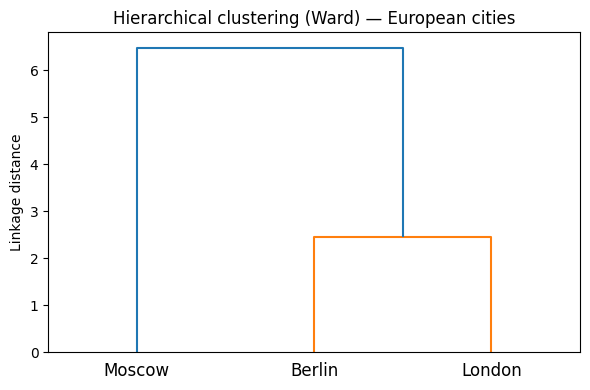

Assigned clusters:


,cluster
city,
Berlin,1
London,1
Moscow,2


In [ ]:
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt

# Ensure numeric matrix
X = df_city.values.astype(float)

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# linkage (Ward)
Z = linkage(X_scaled, method="ward")

# dendrogram
plt.figure(figsize=(6,4))
dendrogram(Z, labels=df_city.index.tolist(), leaf_rotation=0, leaf_font_size=12)
plt.title("Hierarchical clustering (Ward) — European cities")
plt.ylabel("Linkage distance")
plt.tight_layout()
plt.show()

# choose number of clusters (k), e.g., 2
k = 2
labels = fcluster(Z, t=k, criterion="maxclust")
df_city["cluster"] = labels
print("Assigned clusters:")
display(df_city[["cluster"]])

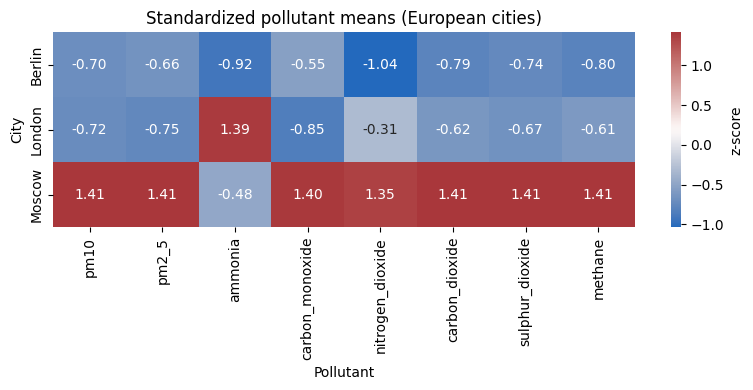

In [ ]:
import seaborn as sns
plt.figure(figsize=(8,4))

# build standardized DataFrame for heatmap (exclude cluster column)
heat_df = pd.DataFrame(X_scaled, index=df_city.index, columns=df_city.columns.drop("cluster") if "cluster" in df_city.columns else df_city.columns)

sns.heatmap(heat_df, annot=True, fmt=".2f", cmap="vlag", cbar_kws={"label": "z-score"})
plt.title("Standardized pollutant means (European cities)")
plt.ylabel("City")
plt.xlabel("Pollutant")
plt.tight_layout()
plt.show()